In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ipywidgets
import pickle
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import optuna
from optuna.integration import lightgbm as lgb

In [2]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [3]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.35,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

# ＜Random Forest＞

In [ ]:
def objective_rf(trial):
    
    param_rf = {
    'n_estimators': 1200,
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    'max_depth': trial.suggest_int('max_depth', 7, 20),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 16),
    'random_state': 1215,
    'verbose': 0
    }
    
    rf = RandomForestClassifier(**param_rf)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(rf, x_train, y_train, scoring=scoring, cv=skf, return_estimator=True)
    
    return cv_output['test_score'].mean()

In [ ]:
%%time

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)
print(study_rf.best_params)
print(study_rf.best_value)
rf_best_params = study_rf.best_params

In [ ]:
rf_best_params

In [ ]:
rf_best_params = {
    'n_estimators': 1200,
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_split': 22,
    'random_state': 18,
    'verbose': 0
}


rf = RandomForestClassifier(**rf_best_params, n_jobs=-1)
rf.fit(x_train, y_train)

In [ ]:
train_score_rf = rf.score(x_train, y_train)
test_score_rf = rf.score(x_test, y_test)

rf_p = rf.predict(x_test)

acc_rf = accuracy_score(rf_p, y_test)
auc_rf = roc_auc_score(rf_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_rf, test_score_rf))
print('acc:{}, auc:{}'.format(acc_rf, auc_rf))

In [ ]:
features = x_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='darkviolet', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [ ]:
pred_rf = rf.predict_proba(test_df)
rf_p = pd.DataFrame(pred_rf)
rf_p.head()

In [ ]:
now = datetime.datetime.now()

rf_name = 'models/RF_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(rf, open(rf_name, 'wb'))

# ＜XGBoost＞

In [5]:
def obj_xgb(trial):
    
    param_xgb = {
        'objective': 'binary:logistic',
        'booster': 'dart',
        'eval_metric': 'auc',
        'eta': 0.01,
        'n_estimators': 1000,
        'early_stopping_rounds': 100,
        'max_depth': trial.suggest_int('max_depth', 7, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.8, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.80, 1.00, 0.05),
        'gamma': 0.0,
        'alpha': 0.0,
        'seed': 18
    }
    
    xgb = XGBClassifier(**param_xgb)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(xgb, x_train, y_train, scoring=scoring, cv=skf)
    
    return cv_output['test_score'].mean()

In [6]:
%%time

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(obj_xgb, n_trials=100)
print(study_xgb.best_params)
print(study_xgb.best_value)
xgb_best_params = study_xgb.best_params

[I 2020-08-28 05:22:03,395] Finished trial#0 resulted in value: 0.8464100736984193. Current best value is 0.8464100736984193 with parameters: {'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.8, 'colsample_bytree': 1.0}.
[I 2020-08-28 05:29:48,398] Finished trial#1 resulted in value: 0.8506338810779287. Current best value is 0.8506338810779287 with parameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[I 2020-08-28 05:39:32,953] Finished trial#2 resulted in value: 0.8403898824117914. Current best value is 0.8506338810779287 with parameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[I 2020-08-28 05:49:59,023] Finished trial#3 resulted in value: 0.8491352319493174. Current best value is 0.8506338810779287 with parameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}.
[I 2020-08-28 06:00:08,703] Finished trial#4 resulted in value: 0.8478259986953361. Current bes

{'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.8}
0.8536475593553243
CPU times: user 3d 3h 54min 39s, sys: 10min 12s, total: 3d 4h 4min 51s
Wall time: 12h 57min 50s


In [7]:
xgb_best_params

{'max_depth': 7,
 'min_child_weight': 5,
 'subsample': 0.8,
 'colsample_bytree': 0.8}

In [6]:
xgb_best_params = {
        'objective': 'binary:logistic',
        'booster': 'dart',
        'eval_metric': 'auc',
        'eta': 0.01,
        'n_estimators': 1000,
        'early_stopping_rounds': 100,
        'max_depth': 7,
        'min_child_weight': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.0,
        'alpha': 0.0,
        'seed': 18
}

xgb_model = XGBClassifier(**xgb_best_params)
xgb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

XGBClassifier(alpha=0.0, base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=100, eta=0.01, eval_metric='auc', gamma=0.0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.00999999978, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=18,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=18,
              subsample=0.8, tree_method=None, validate_parameters=False, ...)

In [7]:
train_score_xgb = xgb_model.score(x_train, y_train)
test_score_xgb = xgb_model.score(x_test, y_test)

xgb_p = xgb_model.predict(x_test)

acc_xgb = accuracy_score(xgb_p, y_test)
auc_xgb = roc_auc_score(xgb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_xgb, test_score_xgb))
print('acc:{}, auc:{}'.format(acc_xgb, auc_xgb))

train score:0.9444791370990633, test_score:0.9319978914074855
acc:0.9319978914074855, auc:0.8356206246634355


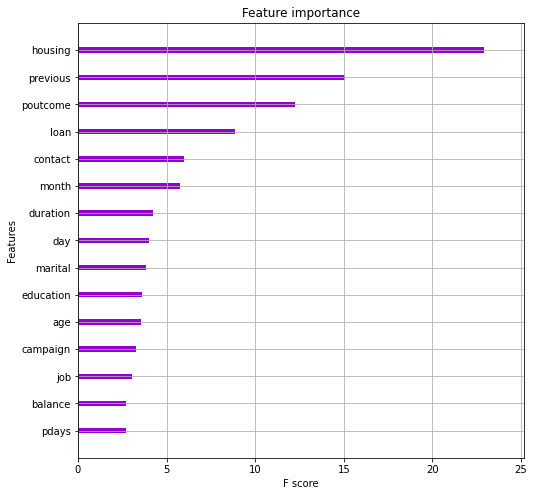

In [8]:
_, ax = plt.subplots(figsize=(8, 8))
xgboost.plot_importance(xgb_model,
                    ax=ax,
                    importance_type='gain',
                    color='darkviolet',
                    show_values=False)
plt.show()

In [9]:
pred_xgb = xgb_model.predict_proba(test_df)
xgb_p = pd.DataFrame(pred_xgb)
xgb_p.head()

,0,1
0,0.271734,0.728266
1,0.887957,0.112043
2,0.979612,0.020388
3,0.997624,0.002376
4,0.964795,0.035205


In [10]:
now = datetime.datetime.now()

xgb_name = 'models/XG_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(xgb_model, open(xgb_name, 'wb'))

# ＜LightGBM＞

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [ ]:
es = 1000

lgb_params = {
    'n_estimations': 10000,
    'learning_rate': 0.001,
    'metric': 'auc',
    'seed': 18
}

In [ ]:
%%time

best_lgb = lgb.train(lgb_params,
                     lgb_train,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=es,
                     verbosity=False)

In [ ]:
lgb_best_params = best_lgb.params
lgb_best_params

In [ ]:
best_itr = best_lgb.best_iteration
best_itr

In [ ]:
best_lgb.best_score

In [ ]:
lgb_model = lgb.train(lgb_best_params,
                     lgb_train,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=es,
                     verbosity=0)

In [ ]:
lgb.plot_importance(lgb_model, figsize=(8,8), color='darkviolet')

In [ ]:
pred_lgb = lgb_model.predict(test_df, num_iteration=best_itr)
lgb_p = pd.DataFrame(pred_lgb)
lgb_p.head()

In [ ]:
now = datetime.datetime.now()

lgb_name = 'models/LGBM_op' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(best_lgb, open(lgb_name, 'wb'))

# ＜CatBoost＞

In [ ]:
train_df = pd.read_csv('dataset/train_cat_16_2206.csv')
test_df = pd.read_csv('dataset/test_cat_16_2206.csv')

In [ ]:
ID = test_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']
test_df = test_df.drop(columns=['y', 'id'])

In [ ]:
cat_features = np.where(x.dtypes != np.float)[0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=18)

In [ ]:
def obj_cb(trial):
    
    param_cb = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 1000,
        'learning_rate': 0.001,
        'depth': trial.suggest_int('depth', 6, 10),
        'od_pval': trial.suggest_loguniform('od_pval', 1e-10, 1e-2),
        'od_wait': 1000,
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'random_strength': trial.suggest_int('random_strength', 1, 3),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 1, 10),
        'random_seed': 18,
        'use_best_model': True
    }
    
    cb = CatBoostClassifier(**param_cb)
    cb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, silent=True)
    predictions = cb.predict(x_test)
    auc_score = roc_auc_score(predictions, y_test)
    
    return auc_score

In [ ]:
def obj_cb2(trial):
    
    param_cb = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 1000,
        'learning_rate': 0.005,
        'depth': trial.suggest_int('depth', 6, 10),
        'od_pval': trial.suggest_loguniform('od_pval', 1e-10, 1e-2),
        'od_wait': 1000,
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 100),
        'random_strength': trial.suggest_int('random_strength', 1, 3),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 1, 10),
        'random_seed': 18,
    }
    
    cb = CatBoostClassifier(**param_cb)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(cb, x_train, y_train, n_jobs=1, scoring=scoring, cv=skf)
    
    return cv_output['test_score'].mean()

In [ ]:
%%time

study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(obj_cb2, n_trials=100, n_jobs=1)

print(study_cb.best_params)
print(study_cb.best_value)
cb_best_params = study_cb.best_params

In [ ]:
cb_best_params

In [ ]:
cb_best_params = {
        'eval_metric': 'AUC',
        'cat_features': cat_features,
        'iterations': 10000,
        'learning_rate': 0.005,
        'depth': 10,
        'od_pval': 0.00000000010051726483293451,
        'od_wait': 1000,
        'l2_leaf_reg': 1,
        'random_strength': 1,
        'bagging_temperature': 9,
        'random_seed': 18,
        'use_best_model': True
}



In [ ]:
cb_model = CatBoostClassifier(**cb_best_params)
cb_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=1000, silent=True)

In [ ]:
cv_params = cb_model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})

cv_data = cv(Pool(x, y, cat_features=cat_features),
            cv_params,
            plot=True)

In [ ]:
train_score_cb = cb_model.score(x_train, y_train)
test_score_cb = cb_model.score(x_test, y_test)

cb_p = cb_model.predict(x_test)

acc_cb = accuracy_score(cb_p, y_test)
auc_cb = roc_auc_score(cb_p, y_test)

print('train score:{}, test_score:{}'.format(train_score_cb, test_score_cb))
print('acc:{}, auc:{}'.format(acc_cb, auc_cb))

In [ ]:
fea_imp = pd.DataFrame({'imp': cb_model.feature_importances_, 'col': x.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), color='darkviolet', legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [ ]:
pred_cb = cb_model.predict_proba(test_df)
cb_p = pd.DataFrame(pred_cb)
cb_p.head()

In [ ]:
now = datetime.datetime.now()

cb_name = 'models/CatBoost_' + now.strftime('%d_%H%M') + '.pkl'
pickle.dump(cb_model, open(cb_name, 'wb'))

# ＜SUBMIT＞

In [ ]:
pred = pd.DataFrame({
    'XGBoost': xgb_p[1],
    'LightGBM': lgb_p[0],
    'CatBoost': cb_p[1]
})

pred.head()

In [ ]:
print(pred.corr())

In [ ]:
print(pred.corr())

In [ ]:
pred['pred'] = pred.XGBoost* 0.2 + pred.LightGBM * 0.8
pred.head(10)

In [ ]:
# ensemble

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [ ]:
# RandomForest

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':rf_p[1]
})

file_name = 'submit/submit_RF' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [12]:
# XGBoost

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':xgb_p[1]
})

file_name = 'submit/submit_XGBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [ ]:
# LightGBM

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':lgb_p[0]
})

file_name = 'submit/submit_LGBM' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)

In [ ]:
# CatBoost

now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':ID,
    'pred':cb_p[1]
})

file_name = 'submit/submit_CatBoost' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, index=False, header=False)